Azure Document Intelligence now supports Semantic Chunking through advances features like hierarchical document structure analysis. Please refer to https://techcommunity.microsoft.com/t5/ai-azure-ai-services-blog/unlocking-advanced-document-insights-with-azure-ai-document/ba-p/4109675 for more details. 

Feature is in Public preview version (2024-02-29-preview) and is currently only available in the following Azure regions:
East US, West US2, West Europe

It uses **Azure AI Document Intelligence** as document loader, which can extracts tables, paragraphs, and layout information from pdf, image, office and html files into **Markdown (MD)** format. The output markdown can be used in **LangChain's Markdown Header splitter** or develop own custom Markdown splitter, which enables **Semantic Chunking** of the documents. Then the chunked documents are indexed into Azure AI Search vectore store. Given a user query, it will use Azure AI Search to get the relevant chunks, then feed the context into the prompt with the query to generate the answer.

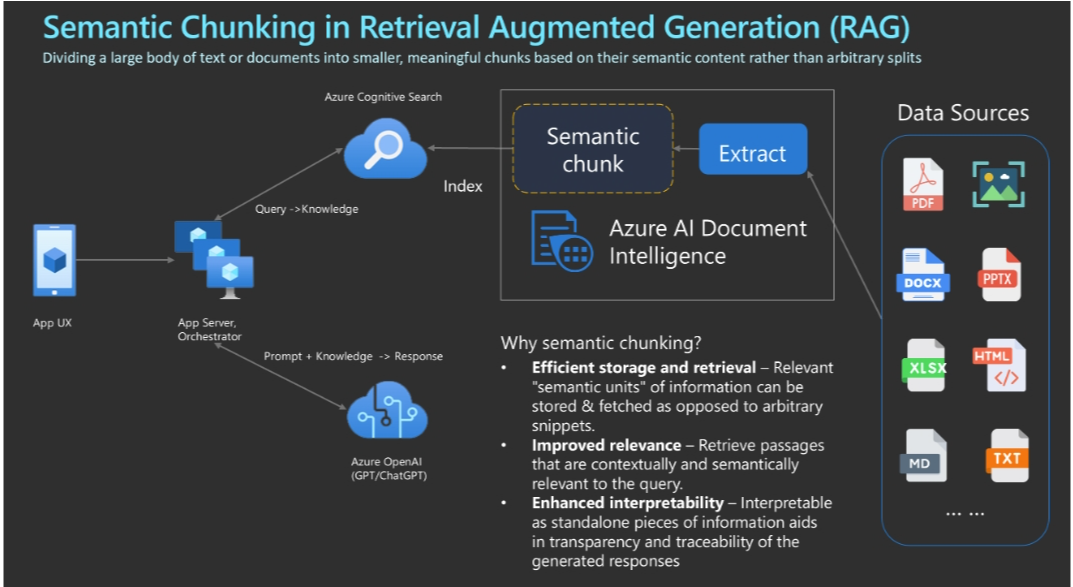

**Setup**

In [1]:
%pip install python-dotenv -q
%pip install langchain -q
%pip install langchain-community -q
%pip install langchain-openai -q
%pip install langchainhub -q
%pip install openai -q
%pip install tiktoken -q
%pip install azure-ai-documentintelligence -q
%pip install azure-identity -q
%pip install azure-search-documents==11.6.0b3 -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from langchain import hub
from langchain_openai import AzureChatOpenAI
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from langchain_openai import AzureOpenAIEmbeddings
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.vectorstores.azuresearch import AzureSearch
from dotenv import load_dotenv
load_dotenv()
import os

**Load the document using AI Document Intelligence prebuilt-layout mode and split it into semantic chunks using MarkdownHeaderTextSplitter**

In [3]:

doc_intelligence_key = os.getenv("DOCUMENT_INTELLIGENCE_KEY")
doc_intelligence_endpoint = os.getenv("DOCUMENT_INTELLIGENCE_ENDPOINT")

# Initiate Azure AI Document Intelligence to load the document. You can either specify file_path or url_path to load the document.
loader = AzureAIDocumentIntelligenceLoader(file_path="./data/books/Azure_AI_Search_Guide.pdf", api_key=doc_intelligence_key, api_endpoint=doc_intelligence_endpoint, api_model="prebuilt-layout")
docs = loader.load()


# Split the document into chunks base on markdown headers.
headers_to_split_on = [
    #("#", "Header 1"),
    ("##", "Header 2"),
    # ("###", "Header 3"),
]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

docs_string = docs[0].page_content
splits = text_splitter.split_text(docs_string)
print("Length of splits: " + str(len(splits)))

Length of splits: 6


**Output the generated MD file for PDF doc and semantic chunks (splits) into results folder**

In [5]:
output_folder = "./results"  # Specify the folder path where you want to save the files
os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist

# Remove all files in the results folder
file_list = os.listdir(output_folder)
for file_name in file_list:
    file_path = os.path.join(output_folder, file_name)
    os.remove(file_path)

file_path = os.path.join(output_folder, "Azure_AI_Search_Guide.MD")  # Specify the file path for the doc_string
with open(file_path, "w") as file:
    file.write(docs_string)

for split in splits:
     # Specify the folder path where you want to save the files
   

    for i, split in enumerate(splits):
        file_path = os.path.join(output_folder, f"split_{i}.MD")  # Specify the file path for each split
        with open(file_path, "w") as file:
            file.write(split.page_content)

**Embed and index the chunks**

In [6]:
# Embed the splitted documents and insert into Azure Search vector store

EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL")
OPENAI_API_VERSION = os.getenv("OPENAI_API_VERSION")

AZURE_OPENAI_API_KEY= os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT= os.getenv("AZURE_OPENAI_ENDPOINT")


aoai_embeddings = AzureOpenAIEmbeddings(
    azure_deployment=EMBEDDING_MODEL,
    openai_api_version=OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
)

vector_store_address = os.getenv("AZURE_SEARCH_ENDPOINT")
vector_store_password = os.getenv("AZURE_SEARCH_ADMIN_KEY")
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME")

index_name: str = "test-chunking-index"
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=vector_store_address,
    azure_search_key=vector_store_password,
    index_name=index_name,
    embedding_function=aoai_embeddings.embed_query,
)

vector_store.add_documents(documents=splits)

['NTE2N2UxOTktNGU2Yy00OWM4LWI1NDgtOWVjMmIwOWU5MGNi',
 'MmEzM2Q3OTctYzczZi00YjMxLTkwMzAtYzFiODVmMmRlMDE5',
 'NzcyOWExOGMtMGQ3ZS00NjhjLTkzMTktNWJjMjdkZDUwOTA4',
 'OWMxMDQwODYtODYzYS00MjZhLTg1OTgtMzg4MmQwMGE0YmZh',
 'OTVlMjMwZGUtODllNy00NWVkLTg1NzMtNWZjYTUwNjQyZjE3',
 'ZWQ2MWYzY2YtYWMzZi00OTNmLTkyOTAtZGQ0NDQwOTUyYzY5']